#### Alexander Lerma

#### Zhiwei Zhang

#### Anoopa Sundararajan

#### Landi Gu

# 2. Model Calibration and Testing

In [26]:
%matplotlib inline
from model.binomial import EuropeanVanillaModel, HullWhiteEuropeanModel, HullWhiteAmericanModel
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### GS Stock Prices (Nov 30, 2016 - Feb 27, 2017)

We chose these dates because they are between dividend paying dates of *Nov 29,2016* and *Feb 28, 2017*

We'll only need closing price from the stock data and will compute the ratio of the closing price for each day

$$ ratio(p_i) = \frac{p_{i+1}}{p_{i}} $$

We use pandas DataFrames to work with out datasets and our data is from yahoo finance.

In [27]:
stock_prices = pd.read_csv('dataset/gs-stock-prices.csv', index_col=0, parse_dates=True).iloc[::-1]
stock_prices['Ratio'] = [np.nan if i + 1 == len(stock_prices) else stock_prices['Close'][i+1] / price for i, price in enumerate(stock_prices['Close'])]
stock_prices.drop([col for col in stock_prices.columns if col not in ['Close', 'Ratio']], axis=1, inplace=True)
stock_prices.head(5)

,Close,Ratio
Date,,
2016-11-30,219.289993,1.033472
2016-12-01,226.630005,0.985571
2016-12-02,223.360001,1.023236
2016-12-05,228.550003,1.012382
2016-12-06,231.380005,1.018065


Now that we have our closing prices and associated ratios, we can start tuning our model using Hull-White. Using 03-17-2017 as our start date, we can determine the inital stock price s0. We determine that our time period T, is the number of days between 03/17/2017 and 06/16/2017 divided by days in a year. delta T (dt or ∆T) is determined by dividing our T period into equal intervals for n steps. We found that the current USD Libor 12 month rate is 1.81317%. 

##### Choice of Stock: 

The Goldman Sachs Group, Inc. (GS)

##### Period of stock used for tuning:

November 29th 2016~February 27th 2017

##### Calibration Method:

Hull-White Model

##### Start Date (t=0): 

03-17-2017 

##### Initial Stock Price (t=0):

243.94

##### USD LIBOR - 12 months on Marth 17, 2017: 
1.81317 %

##### GS Option Expiration Date: 
06-16-2017


In [28]:
start_date = date(2017, 3, 17)
expiration_date = date(2017,6,16)
T = (expiration_date - start_date).days / 365
n_steps = 16
dt = T / n_steps
s0 = 243.94
r = .0181317
n_training = len(stock_prices)

def create_df(option_data, option):
    results = []
    for k in option_data['Strike']:
        american = HullWhiteAmericanModel(k, T, dt, r, n_steps, option, n_training, stock_prices, s0)
        euro = HullWhiteEuropeanModel(k, T, dt, r, n_steps, option, n_training, stock_prices, s0)
        results.append((k, american.price(), euro.price()))
    df = pd.DataFrame(results, columns=['Strike', 'American', 'European'])
    df['Actual'] = option_data['Last Price']
    return df

Now we will read in the gs call option data and compute the theoretical option price using our Hull-White model for both European and American Options.

### Call Option Prices

In [29]:
gs_calls = pd.read_csv('dataset/gs-calls.csv')
option = 'call'
call_df = create_df(gs_calls, option)

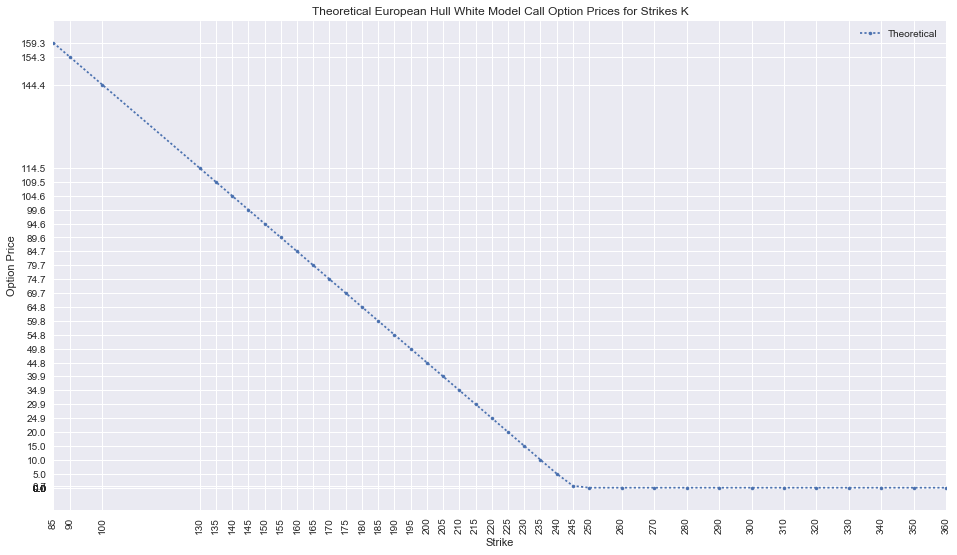

In [30]:
ax = call_df[['Strike','European']].plot(x='Strike', 
                                    y='European',
                                    title='Theoretical European Hull White Model Call Option Prices for Strikes K',
                                    figsize=(16,9),
                                    xticks=call_df['Strike'],
                                    yticks=call_df['European'],
                                    kind='line',
                                    rot=90,
                                    style=[':'],
                                    marker='.')
ax.set_ylabel('Option Price')
ax.legend(['Theoretical'])

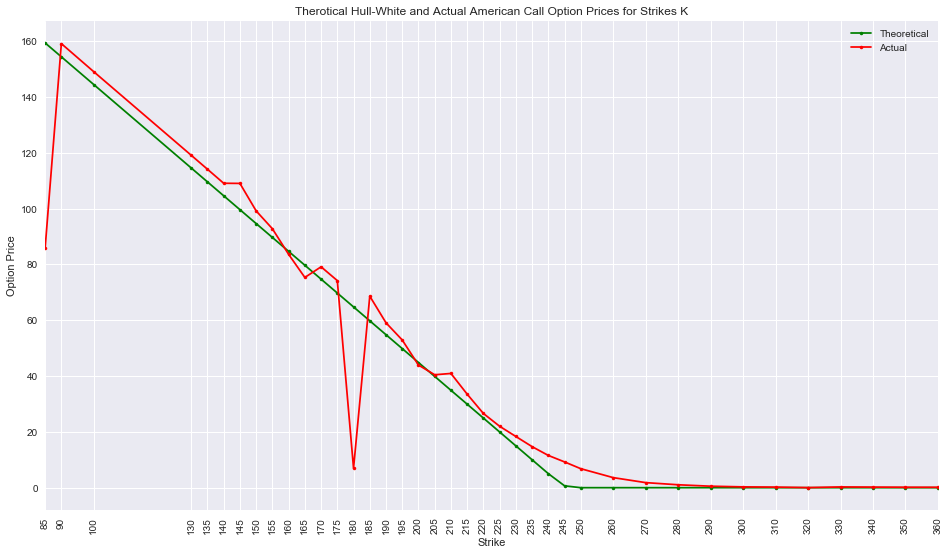

In [31]:
ax = call_df[['Strike','American', 'Actual']].plot(x='Strike', 
                                              title='Therotical Hull-White and Actual American Call Option Prices for Strikes K',
                                              figsize=(16,9),
                                              xticks=call_df['Strike'],
                                              kind='line',
                                              rot=90,
                                              style=['g', 'r'],
                                              marker='.')
ax.set_ylabel('Option Price')
ax.legend(['Theoretical', 'Actual'])

#### Plot of Theoretical American and European Call Prices Compared to Actual Option Price

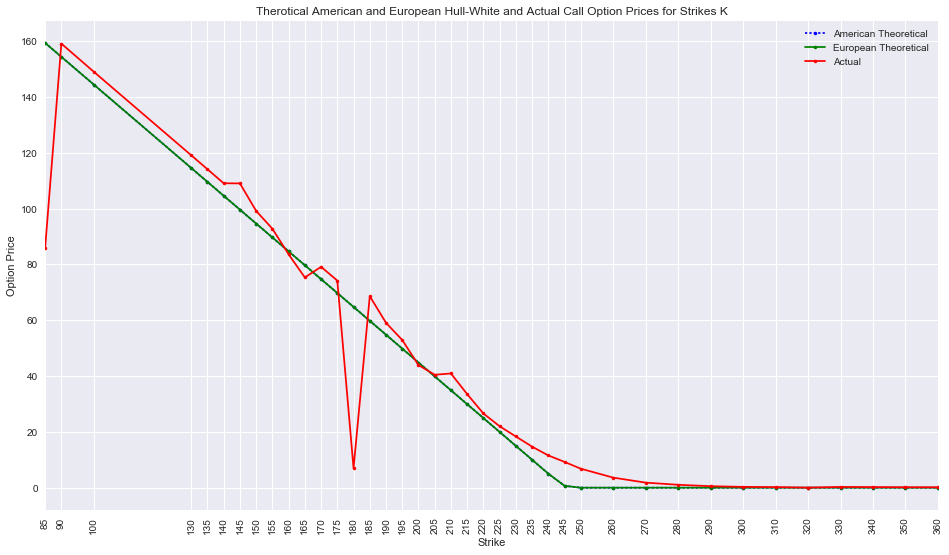

In [32]:
ax = call_df.plot(x='Strike', 
                  title='Therotical American and European Hull-White and Actual Call Option Prices for Strikes K',
                  figsize=(16,9),
                  xticks=call_df['Strike'],
                  kind='line',
                  rot=90,
                  style=[':b', '-g', 'r'],
                  marker='.')
ax.set_ylabel('Option Price')
ax.legend(['American Theoretical', 'European Theoretical', 'Actual'])

#### Findings
From the graph above we see that the price of American call options is higher than that of European put options

### Put Option Prices

In [33]:
gs_puts = pd.read_csv('dataset/gs-puts.csv')
option = 'put'
put_df = create_df(gs_puts, option)

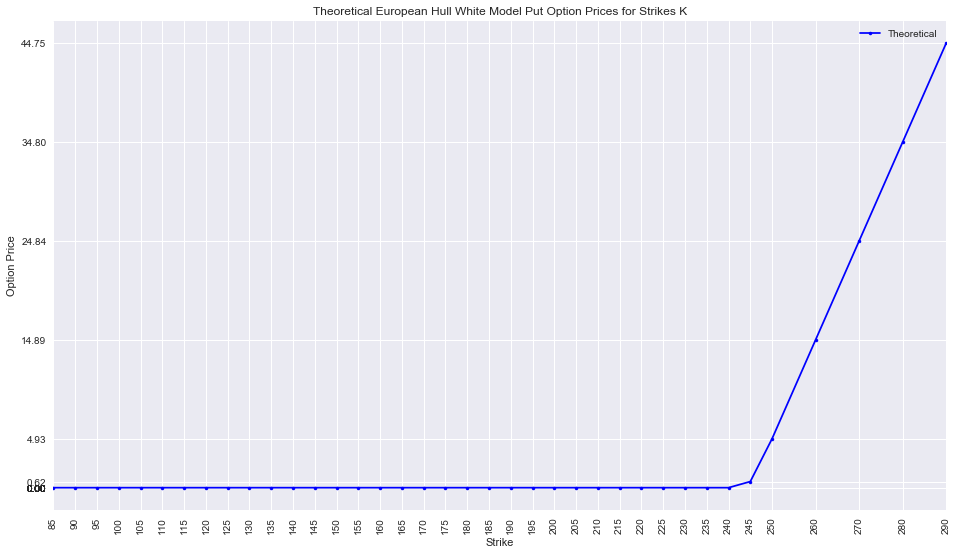

In [34]:
ax = put_df[['Strike','European']].plot(x='Strike', 
                                   y='European',
                                   title='Theoretical European Hull White Model Put Option Prices for Strikes K',
                                   figsize=(16,9),
                                   xticks=put_df['Strike'],
                                   yticks=put_df['European'],
                                   kind='line',
                                   rot=90,
                                   style=['b'],
                                   marker='.')
ax.set_ylabel('Option Price')
ax.legend(['Theoretical'])

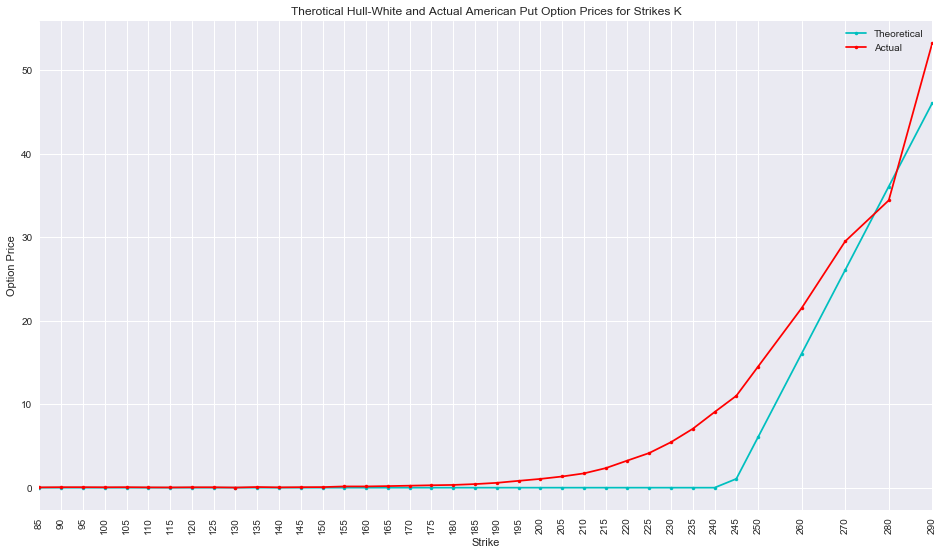

In [35]:
ax = put_df[['Strike','American', 'Actual']].plot(x='Strike', 
                                             title='Therotical Hull-White and Actual American Put Option Prices for Strikes K',
                                             figsize=(16,9),
                                             xticks=put_df['Strike'],
                                             kind='line',
                                             rot=90,
                                             style=['c', 'r'],
                                             marker='.')
ax.set_ylabel('Option Price')
ax.legend(['Theoretical', 'Actual'])

#### Plot of Theoretical American and European Put Prices Compared to Actual Option Price

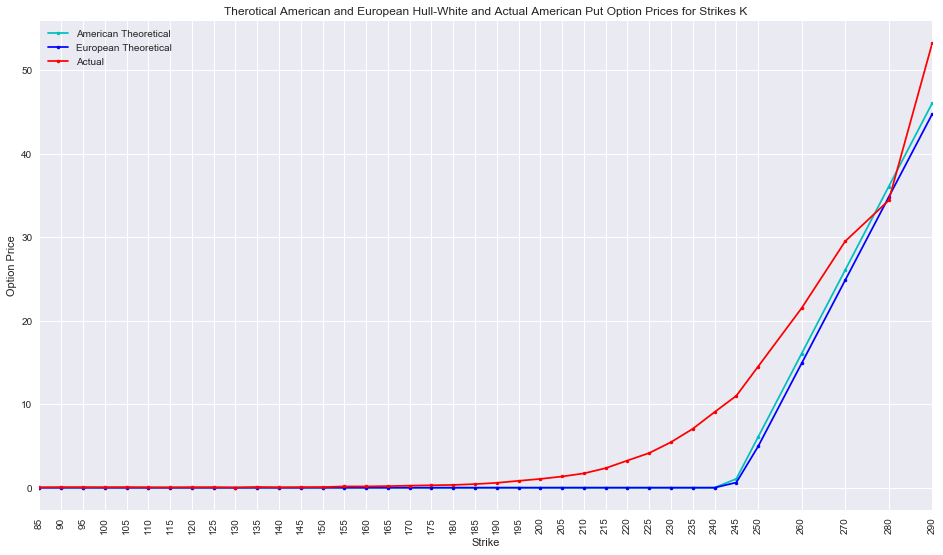

In [38]:
ax = put_df.plot(x='Strike', 
                 title='Therotical American and European Hull-White and Actual American Put Option Prices for Strikes K',
                 figsize=(16,9),
                 xticks=put_df['Strike'],
                 kind='line',
                 rot=90,
                 style=['c', 'b', 'r'],
                 marker='.')
ax.set_ylabel('Option Price')
ax.legend(['American Theoretical', 'European Theoretical', 'Actual'])

#### Findings
From the graph above we see that the price of the American option for put options is higher than that of European put options

### Conclusion

The option prices we computed using our model are very similar to the actual option prices. Although our theoretical prices are not exactly the same as the actual prices, our predictions follow a similar trend. For Call Options, we found that our European and American prices were very similar. For Put options we found that American prices clearly cost more. 